In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm

In [2]:
# FOR XCIT 
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [3]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
train_dir_real = '../Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/train_set_real/'
train_dir_fake = '../Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/train_set_D_fake/'

validation_dir_real = '../Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/validation_set_real/'
validation_dir_fake = '../Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/validation_set_D_fake/'

In [5]:
train_list_real = glob.glob(os.path.join(train_dir_real,'*'))
train_list_fake = glob.glob(os.path.join(train_dir_fake,'*'))

validation_list_real = glob.glob(os.path.join(validation_dir_real,'*'))
validation_list_fake = glob.glob(os.path.join(validation_dir_fake,'*'))

In [6]:
train_list_real = [path.replace('\\','/') for path in train_list_real]
train_list_fake = [path.replace('\\','/') for path in train_list_fake]

validation_list_real = [path.replace('\\','/') for path in validation_list_real]
validation_list_fake = [path.replace('\\','/') for path in validation_list_fake]

In [9]:
all_training_images = []

for i in range(len(train_list_real)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(train_list_real[i]):
        for f in file:
            if '.png' in f and 'mel' not in f and 'mfccs' not in f:
                all_training_images.append(train_list_real[i] + '/' + f)
                

np.random.shuffle(train_list_fake)                
np.random.shuffle(train_list_fake)                
np.random.shuffle(train_list_fake)                
for i in range(2584):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(train_list_fake[i]):
        for f in file:
            if '.png' in f and 'mel' not in f and 'mfccs' not in f:
                all_training_images.append(train_list_fake[i] + '/' + f)

In [10]:
len(all_training_images)

47808

In [8]:
len(all_training_images)

93011

In [9]:
all_validation_images = []

np.random.shuffle(validation_list_real)                
np.random.shuffle(validation_list_real)                
np.random.shuffle(validation_list_real)

for i in range(len(validation_list_real)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(validation_list_real[i]):
        for f in file:
            if '.png' in f and 'mel' not in f and 'mfccs' not in f:
                all_validation_images.append(validation_list_real[i] + '/' + f)

                
np.random.shuffle(all_validation_images)                
np.random.shuffle(all_validation_images)                
np.random.shuffle(all_validation_images)                


all_validation_images = all_validation_images[:9301]

np.random.shuffle(validation_list_fake)                
np.random.shuffle(validation_list_fake)                
np.random.shuffle(validation_list_fake)

fake_all_validation_images = []
for i in range(876):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(validation_list_fake[i]):
        for f in file:
            if '.png' in f and 'mel' not in f and 'mfccs' not in f:
                fake_all_validation_images.append(validation_list_fake[i] + '/' + f)

np.random.shuffle(fake_all_validation_images)                
np.random.shuffle(fake_all_validation_images)                
np.random.shuffle(fake_all_validation_images)

all_validation_images.extend(fake_all_validation_images[:9301])

In [10]:
len(all_validation_images)

18602

In [11]:
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)

np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)

In [12]:
# all_training_images = all_training_images[:5000]
# all_validation_images = all_validation_images[:1000]


In [13]:
print(f"Training Data: {len(all_training_images)}")
# print(f"Train Data Fake: {len(train_list_fake)}")
print('***********************************')
print('***********************************')
print(f"Validation Data: {len(all_validation_images)}")
# print(f"Validation Data Fake: {len(valid_list_fake)}")

Training Data: 93011
***********************************
***********************************
Validation Data: 18602


In [14]:
labels = [path.split('/')[-3].split('_')[-1] for path in all_training_images]
print(labels[:10])

['fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake']


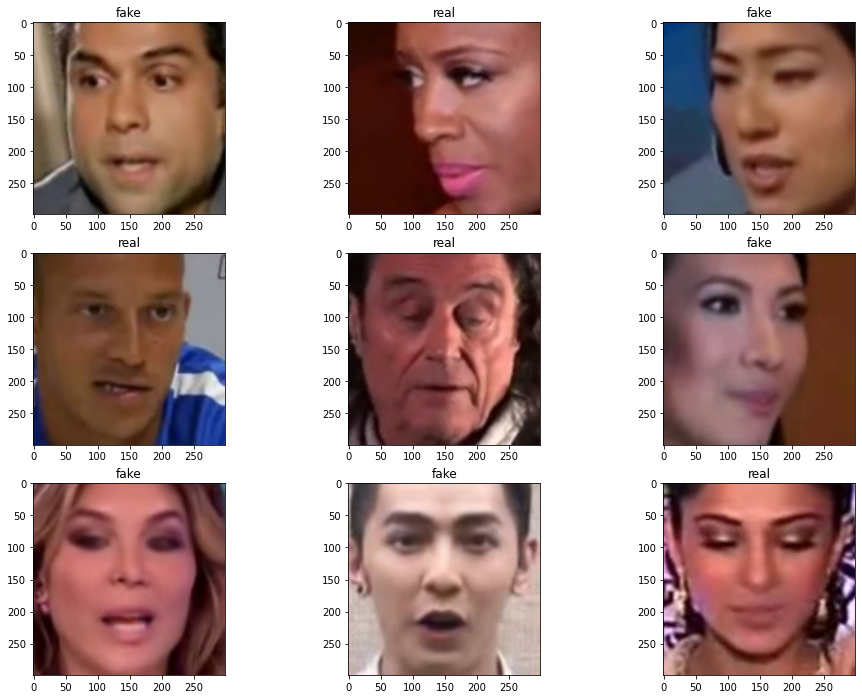

In [15]:
random_idx = np.random.randint(1, len(all_training_images), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
#     frames = sorted(glob.glob(train_list[idx] +'/*.png'))
#     frame = frames[0]
    img = Image.open(all_training_images[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
#         iaa.Crop(px=(0, 16)),
        iaa.Fliplr(0.5), # horizontally flip
        iaa.OneOf([
            iaa.Affine(scale=1.5),
            iaa.Affine(rotate=20),
            iaa.Affine(translate_px=(-20, 20)),
            iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=2, size=0.4)
        ]),
#         iaa.OneOf([
#             iaa.JpegCompression(compression=(60, 70)),
#             iaa.GaussianBlur((0, 1.0)),
#             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3),
#             iaa.Multiply((0.5, 1.0), per_channel=0.2),
#             iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=1, size=0.5)
#                 ])
        ], random_order=True)
      
    def __call__(self, img):
        img = np.array(img).astype(np.uint8)
        img = self.aug.augment_image(img)
        img = torchvision.transforms.ToTensor()(img)
        img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img
transforms_imgaug = ImgAugTransform()

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [17]:
import cv2
import dlib
from imutils import face_utils
import imutils
import numpy as np
import torch

def face_remap(shape):
    remapped_image = cv2.convexHull(shape)
    return remapped_image

def augment_face(detector, predictor, img, random_num):
    frame = cv2.imread(img)
#     frame = img
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    out_face = np.zeros_like(frame)
    # out_face = frame
    faces = detector(gray, 1) 
    if not faces:
        pass
    else:
        for face in faces:
            landmarks = predictor(gray, face)
            shape = face_utils.shape_to_np(landmarks)
            remapped_shape = np.zeros_like(shape) 
            feature_mask = np.zeros((frame.shape[0], frame.shape[1]))

        #Lower face
        if random_num == 1:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[3:14])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes and Mouth
        if random_num == 2:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes, Mouth and Nose
        elif random_num == 3:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower left side of face
        elif random_num == 4:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower right side of face
        elif random_num == 5:
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Nose and Mouth
        elif random_num == 6:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Mouth
        elif random_num == 7:
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        # Eyes and Nose
        elif random_num == 8:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[28:46])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
        
        
        feature_mask = feature_mask.astype(np.bool)
        out_face[feature_mask] = frame[feature_mask]
        frame = frame - out_face
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         cv2.imwrite("out_face.png", frame)
    
    return frame


In [18]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform
        self.to_img = ToPILImage()
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("FaceExtraction/shape_predictor_81_face_landmarks.dat")

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
#         random_num = torch.randint(1, 10, (1,))
#         augmented_face = augment_face(self.detector, self.predictor, img_path, random_num)
#         img_transformed = self.transform(self.to_img(augmented_face))
        img_transformed = self.transform(img)

        label = img_path.split('/')[-3].split('_')[-1]
#         print(label)
        label = 1 if label == "real" else 0
    
        return img_transformed, label

In [19]:
train_data = DeepFakeSet(all_training_images, transform=transforms_imgaug)
valid_data = DeepFakeSet(all_validation_images, transform=val_transforms)

batch_size = 16

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

93011 5814
18602 1163


In [20]:
device = 'cuda'
# device = 'cpu'

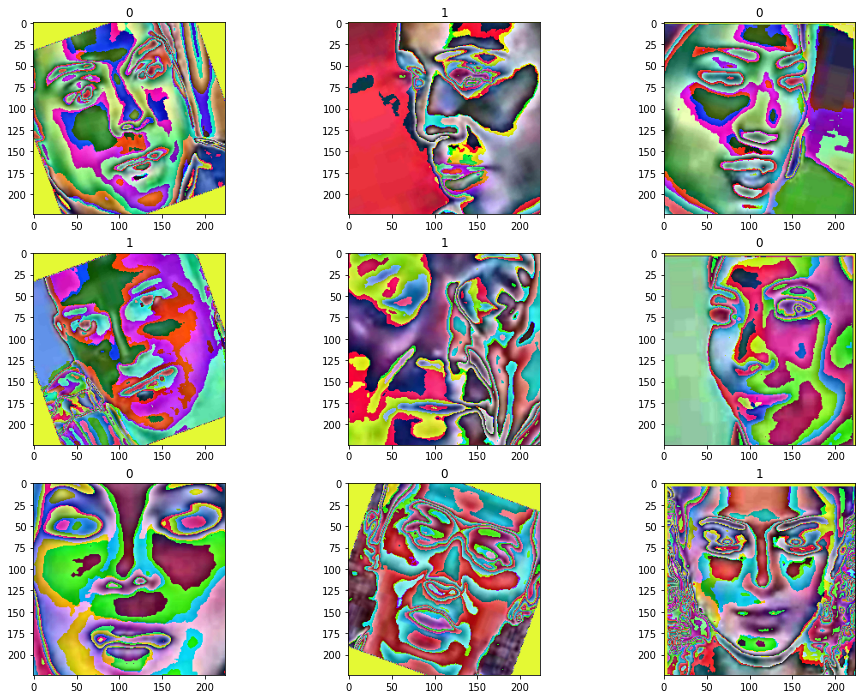

In [21]:
to_img = ToPILImage()

random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = (to_img(train_data[idx][0]))
    ax.set_title(train_data[idx][1])
    ax.imshow(img)

In [58]:
import timm
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']

augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'ForgeryNet']


In [59]:
# Face CutOut Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model)
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[2] + '/' + datasets[0] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training xception


  0%|          | 0/5814 [00:00<?, ?it/s]

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Sohail/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Sohail/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\w600k_r50.onnx recognition
set det-size: (224, 224)


C:\Users\Sohail\AppData\Local\Temp/ipykernel_32208/83397175.py:186: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feature_mask = feature_mask.astype(np.bool)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Sohail/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Sohail/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\w600k_r50.onnx recognition
set det-size: (224, 224)
Applied providers: ['CPUExecutionProvider'], wit

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\w600k_r50.onnx recognition
set det-size: (224, 224)
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Sohail/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Sohail/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Sohail/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], wit

KeyboardInterrupt: 

In [25]:
# Random CutOut Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model)
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[1] + '/' + datasets[0] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training res2net101_26w_4s


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0664 - acc: 0.9726 - val_loss : 0.0712 - val_acc: 0.9762



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0072 - acc: 0.9979 - val_loss : 0.0083 - val_acc: 0.9973



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0039 - acc: 0.9990 - val_loss : 0.3270 - val_acc: 0.9088



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0031 - acc: 0.9991 - val_loss : 0.0053 - val_acc: 0.9989



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0014 - acc: 0.9997 - val_loss : 0.0025 - val_acc: 0.9991

Training tf_efficientnet_b7_ns


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0837 - acc: 0.9728 - val_loss : 0.0260 - val_acc: 0.9913



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0095 - acc: 0.9973 - val_loss : 0.2023 - val_acc: 0.9323



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0055 - acc: 0.9985 - val_loss : 0.0103 - val_acc: 0.9965



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0031 - acc: 0.9991 - val_loss : 0.0077 - val_acc: 0.9983



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0027 - acc: 0.9993 - val_loss : 0.0046 - val_acc: 0.9987

Training vit_base_patch16_224


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4036 - acc: 0.8186 - val_loss : 0.1505 - val_acc: 0.9453



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0525 - acc: 0.9807 - val_loss : 0.1345 - val_acc: 0.9553



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0271 - acc: 0.9904 - val_loss : 0.0915 - val_acc: 0.9712



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0172 - acc: 0.9939 - val_loss : 0.1358 - val_acc: 0.9633



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0137 - acc: 0.9950 - val_loss : 0.1158 - val_acc: 0.9659

Training swin_base_patch4_window7_224


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0863 - acc: 0.9643 - val_loss : 0.0301 - val_acc: 0.9890



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0083 - acc: 0.9972 - val_loss : 0.0156 - val_acc: 0.9942



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0058 - acc: 0.9981 - val_loss : 0.0066 - val_acc: 0.9976



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0041 - acc: 0.9986 - val_loss : 0.0033 - val_acc: 0.9988



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0025 - acc: 0.9992 - val_loss : 0.0049 - val_acc: 0.9983

Training mvitv2_base


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0713 - acc: 0.9686 - val_loss : 0.0028 - val_acc: 0.9996



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0015 - acc: 0.9996 - val_loss : 0.0007 - val_acc: 0.9998



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0035 - acc: 0.9993 - val_loss : 0.0021 - val_acc: 0.9995



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0012 - acc: 0.9997 - val_loss : 0.0013 - val_acc: 0.9996



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0009 - acc: 0.9998 - val_loss : 0.0012 - val_acc: 0.9996



In [23]:
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model)
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[0] + '/' + datasets[0] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    break

Training xception


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1204 - acc: 0.9562 - val_loss : 0.0464 - val_acc: 0.9843



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0186 - acc: 0.9945 - val_loss : 0.0280 - val_acc: 0.9901



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0109 - acc: 0.9973 - val_loss : 0.0218 - val_acc: 0.9930



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0065 - acc: 0.9984 - val_loss : 0.0189 - val_acc: 0.9933



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0040 - acc: 0.9993 - val_loss : 0.0077 - val_acc: 0.9978

Training res2net101_26w_4s


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0441 - acc: 0.9835 - val_loss : 0.0124 - val_acc: 0.9959



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0021 - acc: 0.9996 - val_loss : 0.0088 - val_acc: 0.9969



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0016 - acc: 0.9996 - val_loss : 0.6423 - val_acc: 0.8653



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0016 - acc: 0.9996 - val_loss : 0.0034 - val_acc: 0.9990



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.0052 - val_acc: 0.9982

Training tf_efficientnet_b7_ns


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0509 - acc: 0.9844 - val_loss : 0.0149 - val_acc: 0.9954



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0035 - acc: 0.9991 - val_loss : 0.0088 - val_acc: 0.9970



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0019 - acc: 0.9996 - val_loss : 0.0069 - val_acc: 0.9976



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0014 - acc: 0.9997 - val_loss : 0.0054 - val_acc: 0.9982



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0013 - acc: 0.9998 - val_loss : 0.0119 - val_acc: 0.9959

Training vit_base_patch16_224


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2540 - acc: 0.8985 - val_loss : 0.4359 - val_acc: 0.9002



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0191 - acc: 0.9935 - val_loss : 0.7085 - val_acc: 0.8502



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0088 - acc: 0.9975 - val_loss : 0.3050 - val_acc: 0.9293



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0041 - acc: 0.9987 - val_loss : 0.2106 - val_acc: 0.9513



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.4904 - val_acc: 0.9247

Training swin_base_patch4_window7_224


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1479 - acc: 0.9344 - val_loss : 0.0724 - val_acc: 0.9729



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0055 - acc: 0.9982 - val_loss : 0.0047 - val_acc: 0.9984



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0025 - acc: 0.9992 - val_loss : 0.0063 - val_acc: 0.9982



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0029 - acc: 0.9994 - val_loss : 0.0075 - val_acc: 0.9976



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0014 - acc: 0.9995 - val_loss : 0.0064 - val_acc: 0.9978

Training xcit_medium_24_p16_224


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1950 - acc: 0.9129 - val_loss : 0.2736 - val_acc: 0.9095



  0%|          | 0/5814 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model)
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[0] + '/' + datasets[0] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    break

Training mvitv2_base


  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0571 - acc: 0.9790 - val_loss : 0.0132 - val_acc: 0.9957



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0025 - acc: 0.9994 - val_loss : 0.0065 - val_acc: 0.9980



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0078 - acc: 0.9978 - val_loss : 0.0018 - val_acc: 0.9993



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.0016 - val_acc: 0.9996



  0%|          | 0/5814 [00:00<?, ?it/s]

  0%|          | 0/1163 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0024 - val_acc: 0.9993



# Evaluate

In [26]:
net.eval()


MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

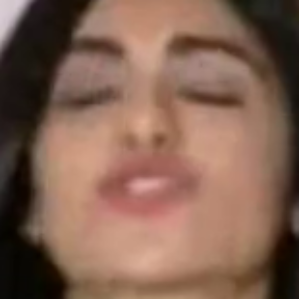

In [33]:
img = Image.open('../Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/test_set_real/id00043/0000.png')
img

In [34]:
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), 
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
img = tfms(img)

In [35]:
labels_map = ["fake", "real"]
# Preprocess image

# Classify

probs = {}
with torch.no_grad():
    outputs = net(img.unsqueeze(0).to(device))
print('-----')
for idx in torch.topk(outputs[0], k=2).indices.tolist():
    prob = torch.softmax(outputs[0], 0)[idx].item()
    probs[idx] = (labels_map[idx], prob*100)
    print((labels_map[idx], prob*100))
#     print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
('real', 99.99690055847168)
('fake', 0.0030946644983487204)


# Write results to CSV

In [23]:
with open(folder_path + 'results.csv', 'w') as csvfile:
    fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

    writer.writeheader()
    for i in range(len(validation_accuracies)):
        writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
    

# Model Parameter Count

In [54]:
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'xcit_medium_24_p16_224', 'cait_s24_224']

net = timm.create_model(models[6], pretrained=True, num_classes=2)

In [40]:
# XCEPTION
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

21.0

In [43]:
# Res2Net 101
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

43.0

In [45]:
# Efficient Net B7
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

64.0

In [47]:
# ViT Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

86.0

In [49]:
# Swin Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

87.0

In [53]:
# XCIT Medium
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

84.0

In [55]:
# CAIT S
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

47.0